In [1]:
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = '1'

In [2]:
BATCH_SIZE = 5
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [5]:
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [6]:
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(layers.Flatten())
finetune_model.add(layers.Dense(64, activation='relu'))
finetune_model.add(layers.Dropout(0.5))
finetune_model.add(layers.Dense(1, activation='sigmoid'))
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 15,239,105
Trainable params: 524,417
Non-trainable params: 14,714,688
_________________________________________________________________


In [8]:
finetune_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [9]:
history = finetune_model.fit(train_generator, epochs=100, validation_data=test_generator, callbacks=[early_stopping])

Epoch 1/100
32/32 [==============================] - 16s 476ms/step - loss: 0.7460 - accuracy: 0.5688 - val_loss: 0.5804 - val_accuracy: 0.7833
Epoch 2/100
32/32 [==============================] - 7s 217ms/step - loss: 0.5437 - accuracy: 0.7563 - val_loss: 0.4836 - val_accuracy: 0.8917
Epoch 3/100
32/32 [==============================] - 7s 218ms/step - loss: 0.4828 - accuracy: 0.7563 - val_loss: 0.4168 - val_accuracy: 0.9083
Epoch 4/100
32/32 [==============================] - 7s 219ms/step - loss: 0.4534 - accuracy: 0.8313 - val_loss: 0.3769 - val_accuracy: 0.9000
Epoch 5/100
32/32 [==============================] - 7s 224ms/step - loss: 0.3602 - accuracy: 0.8938 - val_loss: 0.3362 - val_accuracy: 0.9167
Epoch 6/100
32/32 [==============================] - 7s 218ms/step - loss: 0.3063 - accuracy: 0.9250 - val_loss: 0.3036 - val_accuracy: 0.9167
Epoch 7/100
32/32 [==============================] - 7s 216ms/step - loss: 0.3096 - accuracy: 0.9125 - val_loss: 0.2960 - val_accuracy: 0.891

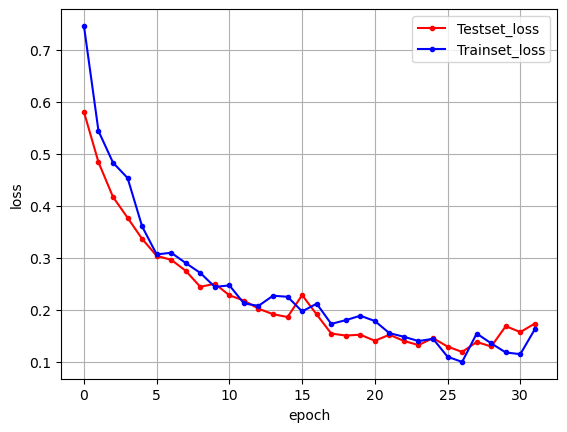

In [10]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()